In [10]:
import numpy as np
from time import time
from numba import cuda
import json
import matplotlib.pyplot as plt
import math

# Gerênciando propriedades constantes

In [11]:
phi = 0.2
cb = 0.15
lambd_nb = 1.8
mi_n = 0.2
lambd_bn = 0.1
y_n = 0.1
Cn_max = 0.55
central_ini_cond = 0.5
ini_cond_var = 0.2

# Serializing json
constant_properties = json.dumps(
    {
        "phi": phi,
        "cb": cb,
        "lambd_nb": lambd_nb,
        "mi_n": mi_n,
        "lambd_bn": lambd_bn,
        "y_n": y_n,
        "Cn_max": Cn_max,
        "central_ini_cond": central_ini_cond,
        "ini_cond_var": ini_cond_var,
    },
    indent=4,
)

# Writing to sample.json
with open("control_dicts/constant_properties.json", "w") as outfile:
    outfile.write(constant_properties)

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
central_ini_cond = constant_properties["central_ini_cond"]
ini_cond_var = constant_properties["ini_cond_var"]

# Gerenciando propriedades de malha

In [12]:
k = 1
t_dom = (0, 10)

# Serializing json
mesh_properties = json.dumps(
    {
        "k": k,
        "t_dom": t_dom,
    },
    indent=4,
)

# Writing to sample.json
with open("control_dicts/mesh_properties.json", "w") as outfile:
    outfile.write(mesh_properties)

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

k = mesh_properties["k"]
t_dom = mesh_properties["t_dom"]

# Inicializando variáveis

In [13]:
def make_init_cond(t_dom):
    n_it = int(((t_dom[1] - t_dom[0]) / (k))) + 1

    initial_cond = np.linspace(
        central_ini_cond * (1 - ini_cond_var),
        central_ini_cond * (1 + ini_cond_var),
        num=n_it,
        endpoint=True,
    )

    print(
        "Steps in time = {:d}\n".format(
            n_it,
        )
    )

    return n_it, initial_cond

# Serial Version

In [14]:
def fb(Cb, Cn, cb, lambd_nb):
    return (cb - lambd_nb * Cn) * Cb


def fn(Cb, Cn, y_n, Cn_max, lambd_bn, mi_n):
    return y_n * Cb * (Cn_max - Cn) - lambd_bn * Cn * Cb - mi_n * Cn


def solve(
    Cb_final,
    Cn_final,
    initial_cond,
    n_it,
    cb,
    lambd_nb,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
):

    for i in range(len(initial_cond)):

        Cb_final[i][0] = initial_cond[i]
        Cn_final[i][0] = 0

        for time in range(1, n_it):

            Cb_final[i][time] = (k / phi) * (
                fb(Cb_final[i][time - 1], Cn_final[i][time - 1], cb, lambd_nb)
            ) + Cb_final[i][time - 1]

            Cn_final[i][time] = (k / phi) * (
                fn(
                    Cb_final[i][time - 1],
                    Cn_final[i][time - 1],
                    y_n,
                    Cn_max,
                    lambd_bn,
                    mi_n,
                )
            ) + Cn_final[i][time - 1]

    return Cb_final, Cn_final

# Parallel Version

In [15]:
@cuda.jit(device=True)
def cu_fb(Cb, Cn, cb, lambd_nb):
    return (cb - lambd_nb * Cn) * Cb


@cuda.jit(device=True)
def cu_fn(Cb, Cn, y_n, Cn_max, lambd_bn, mi_n):
    return y_n * Cb * (Cn_max - Cn) - lambd_bn * Cn * Cb - mi_n * Cn


@cuda.jit()
def cu_solve_pde(
    Cb_final,
    Cn_final,
    initial_cond,
    n_it,
    cb,
    lambd_nb,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
):

    # Domain position
    i = cuda.grid(1)

    Cb_final[i][0] = initial_cond[i]

    for time in range(1, n_it):

        Cb_final[i][time] = (k / phi) * (
            cu_fb(Cb_final[i][time - 1], Cn_final[i][time - 1], cb, lambd_nb)
        ) + Cb_final[i][time - 1]

        Cn_final[i][time] = (k / phi) * (
            cu_fn(
                Cb_final[i][time - 1],
                Cn_final[i][time - 1],
                y_n,
                Cn_max,
                lambd_bn,
                mi_n,
            )
        ) + Cn_final[i][time - 1]

# Comparação entre versões

In [18]:
# Execução serial

n_it, initial_cond = make_init_cond(t_dom)

start = time()

Cb_final = np.zeros((n_it, n_it))
Cn_final = np.zeros((n_it, n_it))

Cb_serial, Cn_serial = solve(
    Cb_final,
    Cn_final,
    initial_cond,
    n_it,
    cb,
    lambd_nb,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
)

end = time()

serial_time = end - start

print("serial_time: {:.6f}s".format(serial_time))

# Execução paralela

start = time()

threadsperblock = n_it
blockspergrid = 1

Cb_final_device = cuda.to_device(np.zeros((n_it, n_it)))
Cn_final_device = cuda.to_device(np.zeros((n_it, n_it)))
initial_cond_device = cuda.to_device(initial_cond)

cu_solve_pde[threadsperblock, blockspergrid](
    Cb_final_device,
    Cn_final_device,
    initial_cond_device,
    n_it,
    cb,
    lambd_nb,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
)

Cb_host = np.empty(shape=Cb_final_device.shape, dtype=Cb_final_device.dtype)
Cb_final_device.copy_to_host(Cb_host)

Cn_host = np.empty(shape=Cn_final_device.shape, dtype=Cn_final_device.dtype)
Cn_final_device.copy_to_host(Cn_host)

end = time()

parallel_time = end - start

print("parallel_time: {:.6f}s".format(parallel_time))

speed_up = serial_time / parallel_time

print("speed_up: {:.6f}".format(speed_up))

Steps in time = 11

serial_time: 0.000213s
parallel_time: 0.007850s
speed_up: 0.027121


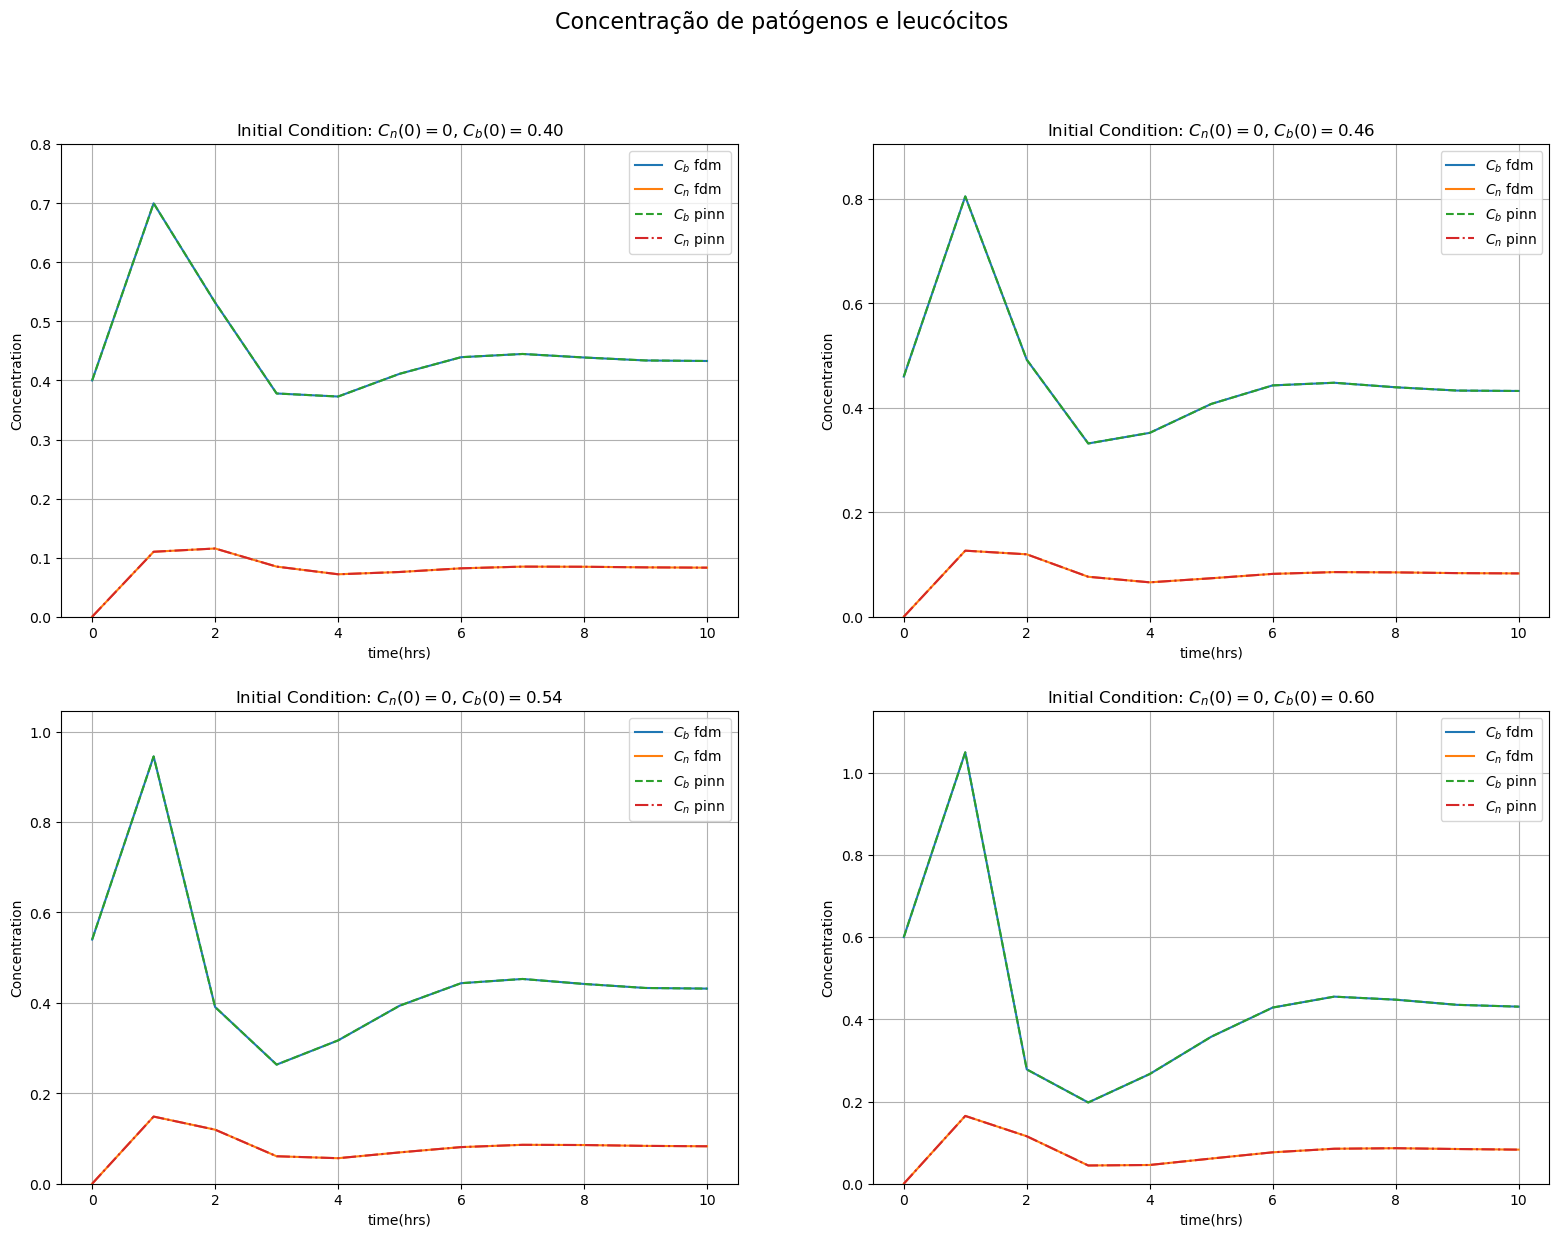

In [17]:
t_np = np.linspace(0, 10, num=n_it, endpoint=True)

tt, ii = np.meshgrid(t_np, initial_cond)

fig = plt.figure(figsize=[16 * 1.2, 9 * 1.5])

fig.suptitle("Concentração de patógenos e leucócitos", fontsize=16)


vmin = 0

ini_cond_plot = [0, 3, 7, 10]

for i, ini_position in enumerate(ini_cond_plot):

    cp_serial = Cb_serial[ini_position, :]
    cl_serial = Cn_serial[ini_position, :]
    cp_parallel = Cb_host[ini_position, :]
    cl_parallel = Cn_host[ini_position, :]
    ini = initial_cond[ini_position]

    # Plotango 3D
    ax = fig.add_subplot(2, 2, i + 1)
    ax.set_title("Initial Condition: $C_n(0) = 0$, $C_b(0) = {:.2f}$".format(ini))

    ax.plot(t_np, cp_serial, label="$C_b$ fdm")
    ax.plot(t_np, cl_serial, label="$C_n$ fdm")
    ax.plot(t_np, cp_parallel, "--", label="$C_b$ pinn")
    ax.plot(t_np, cl_parallel, "-.", label="$C_n$ pinn")
    ax.set_xlabel("time(hrs)")
    ax.set_ylabel("Concentration")

    vmax = np.max(
        [
            np.max(cp_serial),
            np.max(cl_serial),
            np.max(cp_parallel),
            np.max(cl_parallel),
        ]
    )
    ax.set_ylim(vmin, vmax + 0.1)
    ax.legend()
    ax.grid()

plt.show()